In [5]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Cross-Validaition
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from odc.stac import stac_load
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
import stackstac
pc.settings.set_subscription_key('10eb875e826e460b9b84b47e0bf67aa3')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
import statistics
import xarray as xr
tqdm.pandas()

In [6]:
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


In [7]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''
    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    time_of_interest = time_slice
    bands_of_interest = assests
    

    y = 0.00044915/2
    bbox_of_interest = (float(latlong[1])- y , float(latlong[0])+y, float(latlong[1])-y , float(latlong[0])+y)
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    items = list(search.get_all_items())
    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 
    data = stac_load(items,bands=["vv", "vh"], patch_url=pc.sign, bbox=bbox_of_interest, crs="EPSG:4326", resolution=scale)
    mean = data.mean(dim=['latitude','longitude']).compute()

    vh = mean.vh.mean().item()
    vv = mean.vv.mean().item()
    dop = (mean.vv / (mean.vv + mean.vh))
    m = 1 - dop
    rvi = (np.sqrt(m))*((4*mean.vh)/(mean.vv + mean.vh))
    rvi_mean = rvi.mean().item()
    
    #code for sentinel 2
    search_sentinel2 = catalog.search(collections=["sentinel-2-l2a"], bbox=bbox_of_interest, datetime=time_of_interest)
    items_sentinel2 = list(search_sentinel2.get_all_items())
    resolution_sentinel2 = 20  # meters per pixel 
    scale_2 = resolution_sentinel2 / 111320.0 # degrees per pixel for CRS:4326 
    
    S_xx = stac_load(
    items_sentinel2,
    bands=["red", "nir","SCL"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale_2, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=pc.sign,
    bbox=bbox_of_interest
    )
    cloud_mask = \
    (S_xx.SCL != 0) & \
    (S_xx.SCL != 1) & \
    (S_xx.SCL != 3) & \
    (S_xx.SCL != 6) & \
    (S_xx.SCL != 8) & \
    (S_xx.SCL != 9) & \
    (S_xx.SCL != 10) 
    
    cleaned_data = S_xx.where(cloud_mask).astype("uint16")
    mean_clean = cleaned_data.mean(dim=['longitude','latitude']).compute()
    
    ndvi_S= (mean_clean.nir-mean_clean.red)/(mean_clean.nir+mean_clean.red)
    ndvi_sentinel2 = ndvi_S.mean(skipna=True).item()
    
    #code for landsat
    search_landsat = catalog.search(
    collections=["landsat-c2-l2"], 
    bbox=bbox_of_interest, 
    datetime=time_of_interest,
    query={"platform": {"in": ["landsat-8", "landsat-9"]},},
    )
    items_landsat = list(search_landsat.get_all_items())
    
    # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees
    resolution_landsat = 30  # meters per pixel 
    scale_3 = resolution_landsat / 111320.0 # degrees per pixel for CRS:4326 
    
    xx = stac_load(
    items_landsat,
    bands=["red", "nir08", "qa_pixel"],
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale_3, # Degrees
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    bbox=bbox_of_interest
    )
    # Apply scaling and offsets for Landsat Collection-2 (reference below) to the spectral bands ONLY
    # https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2
    xx['red'] = (xx['red']*0.0000275)-0.2
    xx['nir08'] = (xx['nir08']*0.0000275)-0.2
    
    bit_flags = {
            'fill': 1<<0,
            'dilated_cloud': 1<<1,
            'cirrus': 1<<2, 
            'cloud': 1<<3,
            'shadow': 1<<4, 
            'snow': 1<<5, 
            'clear': 1<<6,
            'water': 1<<7
    }
    
    # Create a function that will mask pixels with a given type
    def get_mask(mask, flags_list):

        # Create the result mask filled with zeros and the same shape as the mask
        final_mask = np.zeros_like(mask)

        # Loop through the flags  
        for flag in flags_list:

            # get the mask for each flag
            flag_mask = np.bitwise_and(mask, bit_flags[flag])

            # add it to the final flag
            final_mask = final_mask | flag_mask

        return final_mask > 0
    
    # Calculate the mask for the entire xarray (all time slices)
    full_mask = get_mask(xx['qa_pixel'], ['fill', 'dilated_cloud', 'cirrus', 'cloud', 'shadow', 'water'])
    
   # Create a "clean" dataset with the mask applied 
    cleaned_data2 = xx.where(~full_mask)
    
    mean_clean2 = cleaned_data2.mean(dim=['longitude','latitude']).compute()
    ndvi_mean_clean = (mean_clean2.nir08-mean_clean2.red)/(mean_clean2.nir08+mean_clean2.red)
    ndvi_landsat = ndvi_mean_clean.mean(skipna=True).item()
    
    
    return vh,vv,rvi_mean,ndvi_sentinel2,ndvi_landsat

In [8]:
## Function call to extract VV,VH Values
time_slice = "2021-12-01/2022-04-30"
assests = ['vh','vv']
vh_vv_rvi = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vh_vv_rvi.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_rvi_data = pd.DataFrame(vh_vv_rvi,columns =['vh','vv', 'rvi', 'ndvi_sentinel2','ndvi_landsat'])

100%|██████████| 600/600 [1:18:01<00:00,  7.80s/it]


In [253]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [535]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_rvi_data)
crop_data = crop_data.drop("Latitude and Longitude", axis=1)
for x in crop_data.index:
    if crop_data.loc[x, "vh"] < -5:
        crop_data.drop(x, inplace = True) 
crop_data.count()


Class of Land     593
vh                593
vv                593
rvi               593
ndvi_sentinel2    493
ndvi_landsat      524
dtype: int64

Here I am building 2 linear regression models to predict the missing ndvi values. The first linear regression, model2, is to predict ndi without Class of land. While the second Linear regression model predicts NDVI with all the variables so it is much more accurate. The machine learning algorithnm will be trained using the second linear regression model while the first one will ebe used to predict the initial value of ndvi for the result set.

In [536]:
crop_data_rf = crop_data[['vh','vv','rvi','ndvi_sentinel2']].copy()

test_data = crop_data_rf[crop_data["ndvi_sentinel2"].isnull()]
crop_data_rf.dropna(inplace=True)

y_train = crop_data_rf["ndvi_sentinel2"]
X_train = crop_data_rf.drop("ndvi_sentinel2", axis=1)
X_test = test_data.drop("ndvi_sentinel2", axis=1)

model2 = LinearRegression()
model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)
y_pred

array([0.29988566, 0.32122874, 0.3057932 , 0.31944509, 0.31955507,
       0.32393509, 0.32088746, 0.32571379, 0.32429512, 0.36151909,
       0.31555915, 0.31754818, 0.34335803, 0.31833847, 0.32061905,
       0.3211355 , 0.32650624, 0.3193204 , 0.30937295, 0.32831893,
       0.30522541, 0.33348904, 0.32432011, 0.31376242, 0.32127615,
       0.3174825 , 0.30370633, 0.31320965, 0.31667658, 0.32754767,
       0.30259713, 0.36111886, 0.34256009, 0.33428722, 0.31763644,
       0.31918803, 0.31326307, 0.29685313, 0.3321117 , 0.30754528,
       0.98054917, 0.30761131, 0.39937023, 0.3496773 , 0.31713711,
       0.30778564, 0.31888804, 0.31734175, 0.32768848, 0.42829882,
       0.30312793, 0.29816628, 0.33129998, 0.3095256 , 0.30989548,
       0.31074882, 0.3090041 , 0.30950296, 0.30404133, 0.31265767,
       0.2968201 , 0.30677607, 0.30815396, 0.30390193, 0.3067959 ,
       0.33794833, 0.31479546, 0.30453019, 0.45435979, 0.31596493,
       0.30745451, 0.3190851 , 0.31711539, 0.310194  , 0.31280

In [537]:
crop_data_rf = crop_data[['vh','vv','rvi','ndvi_landsat']].copy()

test_data = crop_data_rf[crop_data_rf["ndvi_landsat"].isnull()]
crop_data_rf.dropna(inplace=True)

y_train = crop_data_rf["ndvi_landsat"]
X_train = crop_data_rf.drop("ndvi_landsat", axis=1)
X_test = test_data.drop("ndvi_landsat", axis=1)

model3 = LinearRegression()
model3.fit(X_train, y_train)

y_pred2 = model3.predict(X_test)
y_pred2

array([0.47400124, 0.46043656, 0.47318421, 0.50539387, 0.49216778,
       0.53132652, 0.4615541 , 0.46676435, 0.48484287, 1.82150716,
       0.46481358, 0.57941922, 0.48464841, 0.46113588, 0.46255435,
       0.46193828, 0.46174104, 0.4576858 , 0.70208549, 0.47113381,
       0.47741015, 0.45075429, 0.47066481, 0.46954868, 0.47179086,
       0.46762688, 0.46792273, 0.47400867, 0.46983824, 0.48373088,
       0.47463869, 0.47423805, 0.47337267, 0.46883649, 0.45527181,
       0.46444668, 0.47920791, 0.68096307, 0.46480268, 0.46641425,
       0.45867832, 0.46404371, 0.46810044, 0.46440328, 0.46555985,
       0.45757662, 0.46582447, 0.46906271, 0.46749303, 0.46695415,
       0.45649244, 0.46477823, 0.4623388 , 0.45919941, 0.4740329 ,
       0.46333232, 0.46425294, 0.46121355, 0.46149878, 0.46232515,
       0.4505399 , 0.46693793, 0.45893063, 0.46673369, 0.48701468,
       0.48411525, 0.46940368, 0.46241085, 0.46072951])

In [538]:
nulls = crop_data[pd.isnull(crop_data["ndvi_sentinel2"])]

for i, ni in enumerate(nulls.index[:len(y_pred)]):
    crop_data['ndvi_sentinel2'].loc[ni] = y_pred[i]

In [539]:
nulls = crop_data[pd.isnull(crop_data["ndvi_landsat"])]

for i, ni in enumerate(nulls.index[:len(y_pred2)]):
    crop_data['ndvi_landsat'].loc[ni] = y_pred2[i]

In [540]:

crop_data.describe()

,vh,vv,rvi,ndvi_sentinel2,ndvi_landsat
count,593.000000,593.000000,593.000000,593.000000,593.000000
mean,0.033701,0.156974,0.444728,0.450322,0.663998
std,0.021717,0.095074,0.095486,0.123583,0.187902
min,0.004675,0.012922,0.217839,0.008775,0.024116
25%,0.021165,0.110346,0.371050,0.327375,0.538651
50%,0.026571,0.142643,0.432535,0.461231,0.755421
75%,0.051939,0.214244,0.506535,0.565817,0.807744
max,0.156665,0.941301,0.749013,0.980549,1.821507


In [541]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

In [542]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[-0.69814133, -0.46922694, -0.45697076,  0.71028392,  0.96424669],
       [-0.33784585, -0.14979006, -0.61438818,  0.56635865,  0.7816469 ],
       [ 0.58681557,  0.32455444, -0.56404071,  0.90286669,  0.71673545],
       ...,
       [-0.58075693, -0.66806898, -0.40710512, -0.30705525, -0.46284137],
       [-0.52003069, -0.206441  , -1.25414247,  0.35130793,  0.86316114],
       [-0.55205288, -0.12545624, -1.22533167,  0.05611031,  0.77624665]])

In [543]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)
model.score(X_train,y_train)

0.8578313253012049

In [544]:
svm = SVC()
svm.fit(X_train,y_train)
svm.score(X_train,y_train)

0.9975903614457832

In [545]:
rf = RandomForestClassifier(n_estimators=40)
rf.fit(X_train,y_train)
rf.score(X_train,y_train)

1.0

In [546]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
knn.score(X_train,y_train)

0.9951807228915662

In [549]:
clf = rf
sk_folds = StratifiedKFold(n_splits = 10, shuffle=True, random_state=40)
scores = cross_val_score(clf, X, y, cv = sk_folds)

scores.mean()

0.9898587570621469

In [548]:
insample_predictions = knn.predict(X_train)

In [514]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 98.81%
              precision    recall  f1-score   support

    Non Rice       0.99      0.99      0.99       209
        Rice       0.99      0.99      0.99       211

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420



In [515]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

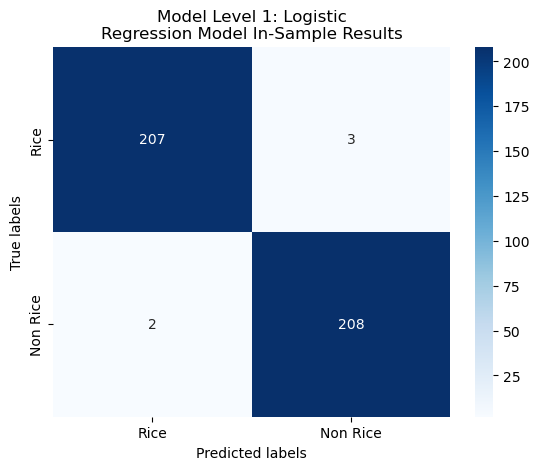

In [516]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: Logistic\nRegression Model In-Sample Results",['Rice', 'Non Rice'])

In [517]:
outsample_predictions = knn.predict(X_test)

In [518]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 98.33%
              precision    recall  f1-score   support

    Non Rice       1.00      0.97      0.98        90
        Rice       0.97      1.00      0.98        90

    accuracy                           0.98       180
   macro avg       0.98      0.98      0.98       180
weighted avg       0.98      0.98      0.98       180



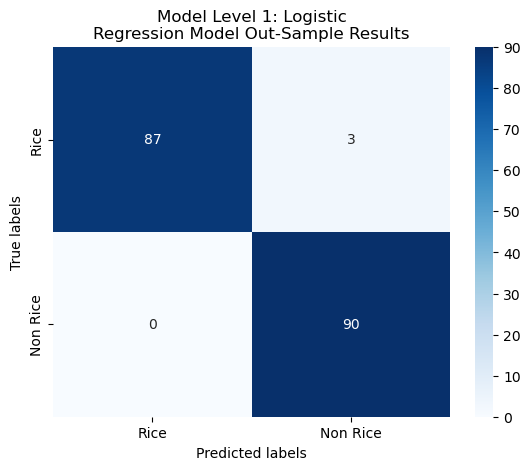

In [519]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: Logistic\nRegression Model Out-Sample Results",['Rice', 'Non Rice'])

Submission

In [385]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template_correct_columns_fixed.csv')
test_file.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [13]:
## Get Sentinel-1-RTC Data
time_slice = "2021-12-01/2022-04-30"
assests = ['vh','vv']
vh_vv_rvi = []
for coordinates in tqdm(test_file['id']):
    vh_vv_rvi.append(get_sentinel_data(coordinates,time_slice,assests))
submission_vh_vv_data = pd.DataFrame(vh_vv_rvi,columns =['vh','vv', 'rvi','ndvi_sentinel2','ndvi_landsat'])

100%|██████████| 250/250 [37:47<00:00,  9.07s/it]


In [550]:
#submission_vh_vv_data = submission_vh_vv_data.fillna(value=submission_vh_vv_data['ndvi'].min())
submission_vh_vv_data.describe()

,vh,vv,rvi,ndvi_sentinel2,ndvi_landsat
count,250.000000,250.000000,250.000000,204.000000,221.000000
mean,0.034266,0.156732,0.448377,0.492987,0.629756
std,0.024662,0.121598,0.110063,0.116253,0.172491
min,0.003982,0.012465,0.189425,0.204502,0.101055
25%,0.018170,0.089014,0.370757,0.419490,0.550059
50%,0.026618,0.132548,0.438541,0.468683,0.643664
75%,0.050576,0.229456,0.525959,0.579918,0.759458
max,0.140220,1.174001,0.863866,0.729237,0.860514


In [551]:
crop_data_rf_ver1 = submission_vh_vv_data[['vh','vv','rvi','ndvi_sentinel2']].copy()

test_data_ver1 = crop_data_rf_ver1[crop_data_rf_ver1['ndvi_sentinel2'].isnull()]

X_test_ver1 = test_data_ver1.drop("ndvi_sentinel2", axis=1)


y_pred_ver1 = model2.predict(X_test_ver1)

In [552]:
crop_data_rf_ver2 = submission_vh_vv_data[['vh','vv','rvi','ndvi_landsat']].copy()

test_data_ver2 = crop_data_rf_ver2[crop_data_rf_ver2['ndvi_landsat'].isnull()]

X_test_ver2 = test_data_ver2.drop("ndvi_landsat", axis=1)


y_pred_ver2 = model3.predict(X_test_ver2)

In [553]:
version1_submission_vh_vv_data = submission_vh_vv_data.copy()

In [554]:
nulls2 = version1_submission_vh_vv_data[pd.isnull(version1_submission_vh_vv_data["ndvi_sentinel2"])]

for i, ni in enumerate(nulls2.index[:len(y_pred_ver1)]):
    version1_submission_vh_vv_data['ndvi_sentinel2'].loc[ni] = y_pred_ver1[i]

In [555]:
nulls5 = version1_submission_vh_vv_data[pd.isnull(version1_submission_vh_vv_data["ndvi_landsat"])]

for i, ni in enumerate(nulls5.index[:len(y_pred_ver2)]):
    version1_submission_vh_vv_data['ndvi_landsat'].loc[ni] = y_pred_ver2[i]

In [556]:
version1_submission_vh_vv_data.describe()

,vh,vv,rvi,ndvi_sentinel2,ndvi_landsat
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.034266,0.156732,0.448377,0.463215,0.614727
std,0.024662,0.121598,0.110063,0.124401,0.170223
min,0.003982,0.012465,0.189425,0.204502,0.101055
25%,0.018170,0.089014,0.370757,0.360467,0.502212
50%,0.026618,0.132548,0.438541,0.451910,0.633551
75%,0.050576,0.229456,0.525959,0.536852,0.740282
max,0.140220,1.174001,0.863866,0.729237,0.860514


In [557]:
# Feature Scaling 
version1_submission_vh_vv_data = version1_submission_vh_vv_data.values
version1_transformed_submission_data = sc.transform(version1_submission_vh_vv_data)
version1_transformed_submission_data

array([[-0.8326478 , -0.58990949, -0.72307079, -0.48089299, -0.15519323],
       [-0.81404522, -0.9285848 ,  0.38271531,  0.03956471, -0.1179224 ],
       [-0.59836592, -0.28567883, -0.60544607, -0.08375766, -0.66633314],
       ...,
       [-1.37890876, -1.50514648,  0.86370196, -1.17384264, -1.32022589],
       [-0.61772222, -0.70636198,  0.30646522, -0.07505754, -0.82280287],
       [-0.23653542, -0.19981645,  0.19873675, -0.6622172 , -0.35441888]])

In [559]:
#Making predictions
final_predictions = knn.predict(version1_transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)
final_predictions

array(['Rice', 'Rice', 'Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice',
       'Rice', 'Non Rice', 'Rice', 'Rice', 'Rice', 'Rice', 'Non Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice',
       'Rice', 'Non Rice', 'Rice', 'Non Rice', 'Rice', 'Rice', 'Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Rice', 'Rice', 'Rice',
       'Rice', 'Rice', 'Non Rice', 'Non Rice', 'Non Rice', 'Rice', 'Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Rice', 'Non Rice', 'Non Rice',
       'Rice', 'Rice', 'Rice', 'Non Rice', 'Non Rice', 'Non Rice',
       'Non Rice', 'Non Rice', 'Non Rice', 'Rice', 'Rice', 'Rice',
       'Non Rice', 'Rice', 'Rice', 'Rice', 'Non Rice', 'Non Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice',
       'Non Rice', 'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Rice',
       'Rice', 'Non Rice', 'Non Rice', 'Non Rice', 'Non Rice', 'Non Rice',
       'Non Rice', 'Rice', 'Non Rice', 'Non Rice', 'Non Rice', 'Non Rice'

In [356]:
# Combining the results into dataframe
#submission_df_ver1 = pd.DataFrame({'id':test_file['id'].values, 'target':final_prediction_series_ver1.values})
submission_df = pd.DataFrame({'id':test_file['id'].values, 'target':final_prediction_series.values})
submission_df.to_csv("challenge_1_submission_rice_crop_prediction8.csv",index = False)

In [318]:
#ver1_test_data = combine_two_datasets(submission_df_ver1,submission_vh_vv_data)

#ver1_test_data.head()

#ML_data = ver1_test_data.copy()
#ML_data = ML_data.drop(columns=['target'])
#ver1_test_data.head(50)

,target,vh,vv,rvi,ndvi
0,Rice,0.016303,0.102889,0.371056,0.392887
1,Rice,0.016699,0.070609,0.478301,0.458604
2,Rice,0.021289,0.131887,0.382464,0.443033
3,Rice,0.004188,0.014150,0.560239,NaN
4,Rice,0.014397,0.124022,0.311360,0.450690
5,Rice,0.004607,0.015166,0.609806,NaN
6,Rice,0.053301,0.174903,0.557832,0.426739
7,Rice,0.026188,0.096142,0.446935,0.497216
8,Rice,0.004396,0.012813,0.617763,NaN
9,Rice,0.029523,0.114575,0.584138,0.457516


once version 1 of test data (less accurate ndvi data) predicted class of land, use it to repredict ndvi for btr accuracy

In [319]:
#crop_data_ver2 = ver1_test_data[['target','vh','vv','rvi','ndvi']]

#crop_data_ver2['target'] = [1 if x=="Rice" else 0 for x in crop_data_ver2['target']]

#test_data_ver2 = crop_data_ver2[crop_data_ver2["ndvi"].isnull()]

#X_test_ver2 = test_data_ver2.drop("ndvi", axis=1)


#y_pred_ver2 = model2.predict(X_test_ver2)
#y_pred_ver2

array([-0.25443408, -0.26100015, -0.26265173, -0.24950505, -0.25489028,
       -0.24354889, -0.25702196, -0.24060864, -0.25062723, -0.24296103,
       -0.28261352, -0.24975329, -0.24459706, -0.25304605, -0.24621486,
       -0.26431757,  0.36620659, -0.23636945, -0.24477947, -0.25810859,
       -0.24955879, -0.27191292, -0.23688361, -0.28285493, -0.23513033,
       -0.25479539, -0.2733658 , -0.2394915 , -0.25225183, -0.24979361,
       -0.26018748, -0.27703527, -0.26255932, -0.2695974 , -0.25785449,
       -0.24213756, -0.26086664, -0.27455185,  0.34145274, -0.24018535,
       -0.19755341, -0.2804404 , -0.25687427, -0.24785895,  0.37473921,
       -0.2489137 ])

In [320]:

#nulls3 = ML_data[pd.isnull(ML_data["ndvi"])]

#for i, ni in enumerate(nulls3.index[:len(y_pred_ver2)]):
    ML_data['ndvi'].loc[ni] = y_pred_ver2[i]


In [321]:
#ML_data.describe()

,vh,vv,rvi,ndvi
count,250.000000,250.000000,250.000000,250.000000
mean,0.034266,0.156732,0.448377,0.362928
std,0.024662,0.121598,0.110063,0.301056
min,0.003982,0.012465,0.189425,-0.282855
25%,0.018170,0.089014,0.370757,0.358338
50%,0.026618,0.132548,0.438541,0.449100
75%,0.050576,0.229456,0.525959,0.533865
max,0.140220,1.174001,0.863866,0.729237


In [322]:
# Feature Scaling 
ML_data = ML_data.values
transformed_ML_data = sc.transform(ML_data)

In [325]:
#Making predictions final
#final_predictions_ver2 = rf2.predict(transformed_ML_data)
#final_prediction_series_ver2 = pd.Series(final_predictions_ver2)
#final_prediction_series_ver2.head(20)

0     Non Rice
1     Non Rice
2     Non Rice
3     Non Rice
4     Non Rice
5     Non Rice
6     Non Rice
7     Non Rice
8     Non Rice
9     Non Rice
10    Non Rice
11    Non Rice
12    Non Rice
13    Non Rice
14    Non Rice
15    Non Rice
16    Non Rice
17    Non Rice
18    Non Rice
19    Non Rice
dtype: object

In [268]:
#Combining the results into dataframe
#submission_df_ver2 = pd.DataFrame({'id':test_file['id'].values, 'target':final_prediction_series_ver2.values})

In [204]:
#Dumping the predictions into a csv file.
#submission_df_ver2.to_csv("challenge_1_submission_rice_crop_prediction6.csv",index = False)